In [5]:
import os
import pickle
import json
from pathlib import Path
from typing import Any, Dict, Optional

from dotenv import load_dotenv
from pydantic import BaseModel

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.memory import ConversationBufferMemory
from langchain_community.document_loaders import JSONLoader
from langchain.document_loaders import PyPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_astradb import AstraDBVectorStore
from langchain.vectorstores import FAISS
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END


load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
ASTRA_API_KEY = os.getenv("ASTRA_API_KEY")
DB_ENDPOINT = os.getenv("DB_ENDPOINT")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GEMINI_API_KEY,
    temperature=0.2,
)


from langchain.memory import ConversationBufferMemory

class DiskConversationMemory:
    def __init__(self, filename="chat_memory.pkl"):
        self.filename = Path(filename)
        self.memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
        self._load()

    def _load(self):
        if self.filename.exists():
            try:
                with open(self.filename, "rb") as f:
                    self.memory = pickle.load(f)
                print(f"Loaded memory from {self.filename}")
            except Exception as e:
                print("Failed to load memory, starting fresh:", e)

    def persist(self):
        try:
            with open(self.filename, "wb") as f:
                pickle.dump(self.memory, f)
                print(f"Persisted memory to {self.filename}")
        except Exception as e:
            print("Failed to persist memory:", e)

class HealthGraphState(BaseModel):
    twilio_payload: Optional[Dict[str, Any]] = None
    user_message: Optional[str] = None
    user_meta: Optional[Dict[str, Any]] = None
    vaccination_docs: Optional[Any] = None
    outbreak_docs: Optional[Any] = None
    local_vectorstore: Optional[Any] = None
    disk_memory: Optional[Any] = None
    route_decision: Optional[Dict[str, str]] = None
    response: Optional[str] = None
    vaccination_json_path: Optional[str] = (
        r"/Users/aashutoshkumar/Documents/Projects/healthgraph-assistant/data/vaccination_schedule.json"
    )
    outbreak_pdf_path: Optional[str] = (
        r"/Users/aashutoshkumar/Documents/Projects/healthgraph-assistant/latest_weekly_outbreak/31st_weekly_outbreak.pdf"
    )
    index_dir: Optional[str] = (
        r"/Users/aashutoshkumar/Documents/Projects/healthgraph-assistant/exp/faiss_index/index.faiss"
    )


def node_twilio_ingress(state: HealthGraphState) -> HealthGraphState:
    payload = state.twilio_payload
    if not payload:
        return state

    text = payload.get("Body") or payload.get("Message") or payload.get("text")
    sender = payload.get("From") or payload.get("from")

    state.user_message = text
    state.user_meta = {"sender": sender, "raw_payload": payload}
    return state


def node_load_vaccination_json(state: HealthGraphState) -> HealthGraphState:
    loader = JSONLoader(file_path=state.vaccination_json_path)
    docs = loader.load()
    state.vaccination_docs = docs
    return state


def node_load_outbreak_pdf(state: HealthGraphState) -> HealthGraphState:
    loader = PyPDFLoader(state.outbreak_pdf_path)
    docs = loader.load_and_split()
    state.outbreak_docs = docs
    return state

# def node_build_faiss_index(state: HealthGraphState) -> HealthGraphState:
#     hf_embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

#     docs = state.outbreak_docs or []
#     if not docs:
#         print("No outbreak documents found to index.")
#         return state

#     index_dir = Path(state.index_dir).parent
#     index_dir.mkdir(parents=True, exist_ok=True)

#     vectorstore = FAISS.from_documents(docs, embedding=hf_embedding)
#     vectorstore.save_local(str(index_dir))

#     state.local_vectorstore = vectorstore
#     print(f"FAISS index built with {len(docs)} docs and saved to {index_dir}")
#     return state

from langchain.vectorstores import FAISS

def node_build_faiss_index(state: HealthGraphState) -> HealthGraphState:
    hf_embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

    index_dir = Path(state.index_dir).parent
    index_dir.mkdir(parents=True, exist_ok=True)

    faiss_file = Path(state.index_dir)

    if faiss_file.exists():
        state.local_vectorstore = FAISS.load_local(str(index_dir), hf_embedding, allow_dangerous_deserialization=True)
        print(f"Loaded FAISS index from {index_dir}")
        return state

    docs = state.outbreak_docs or []
    if not docs:
        print("No outbreak documents found to index.")
        return state

    vectorstore = FAISS.from_documents(docs, embedding=hf_embedding)
    vectorstore.save_local(str(index_dir))

    state.local_vectorstore = vectorstore
    print(f"Built new FAISS index with {len(docs)} docs and saved to {index_dir}")
    return state


def node_router(state: HealthGraphState) -> HealthGraphState:
    message = state.user_message or ""
    if not message.strip():
        state.route_decision = {"route": "general_query", "reason": "empty_message"}
        return state

    prompt = f"""
    You are a classifier. 
    Categorize the user's query into one of these routes:
    if the query is asking about outbreaks in his/her area route to emergency_outbreak.
    if the query is regarding any medical condition then route to symptom for efficient RAG.
    if the query is regrading the vaccination schedule then route to vaccination_schedule.
    if you cant classify the query in any of the given classes then route to general_query.

    - emergency_outbreak
    - symptom
    - vaccination_schedule
    - general_query

    Query: "{message}"

    Reply ONLY with a valid route name.
    """

    result = llm.invoke(prompt).content.strip().lower()
    print(result)

    valid_routes = {"emergency_outbreak", "symptom", "vaccination_schedule", "general_query"}
    route = result if result in valid_routes else "general_query"

    state.route_decision = {"route": route, "reason": "llm_classified"}
    return state


def node_emergency_outbreak(state: HealthGraphState) -> HealthGraphState:
    if not state.user_message:
        state.response = "No message provided."
        return state
    if not state.local_vectorstore:
        state.response = "Outbreak data not indexed."
        return state

    retriever = state.local_vectorstore.as_retriever(search_kwargs={"k": 5})
    conv = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=retriever,
        memory=state.disk_memory.memory if state.disk_memory else None,
        return_source_documents=False,
    )
    result = conv.run(question=state.user_message)
    state.response = result
    if state.disk_memory:
        state.disk_memory.persist()
    return state

def node_symptom(state: HealthGraphState) -> HealthGraphState:
    hf_embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vector_store = AstraDBVectorStore(
        embedding=hf_embedding,
        api_endpoint=DB_ENDPOINT,
        namespace="default_keyspace",
        token=ASTRA_API_KEY,
        collection_name="medical_v2",
    )
    retriever = vector_store.as_retriever()
    
    prompt = PromptTemplate(
        input_variables=["context", "question"],
        template="You are a medical assistant.\nContext:\n{context}\n\nQuestion:\n{question}\nAnswer clearly and answer in simple terms."
    )
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt},
    )
    state.response = qa_chain.run(state.user_message)
    return state

def node_vaccination_schedule(state):
    message = state.user_message
    if not message:
        return state

    vaccination_json_path = state.vaccination_json_path

    try:
        with open(vaccination_json_path, "r", encoding="utf-8") as f:
            schedule_data = json.load(f)
        docs_json_str = json.dumps(schedule_data, ensure_ascii=False, indent=2)
    except Exception as e:
        state.response = f"(unable to load vaccination schedule JSON: {e})"
        return state

    prompt = f"""
        You are an assistant that knows how to infer vaccination due-dates from a vaccination schedule JSON.
        Use the provided schedule to answer the question as precisely as possible and, when appropriate, return a short checklist.

        SCHEDULE_JSON:
        {docs_json_str}

        QUESTION:
        {message}
    """

    answer = llm.invoke(prompt)
    state.response = answer.content  
    return state


def node_general_query(state: HealthGraphState) -> HealthGraphState:
    resp = llm.invoke([{"role": "user", "content": state.user_message}]).content
    state.response = resp
    return state

def node_route_dispatcher(state: HealthGraphState) -> HealthGraphState:
    route = state.route_decision["route"] if state.route_decision else "general_query"
    if route == "emergency_outbreak":
        return node_emergency_outbreak(state)
    if route == "symptom":
        return node_symptom(state)
    if route == "vaccination_schedule":
        return node_vaccination_schedule(state)
    return node_general_query(state)

def node_translation(state: HealthGraphState) -> HealthGraphState:
    if not state.response:
        state.response = "No response to translate."
        return state

    prompt = f"""
    You are a translation assistant. 
    Take the following text and translate it into **Odia** and **Telugu**.

    TEXT: {state.response}
    """

    result = llm.invoke(prompt)
    try:
        state.response = json.loads(result.content) 
    except Exception:
        state.response = {"original": state.response, "translation_raw": result.content}

    return state



workflow = StateGraph(HealthGraphState)
workflow.add_node("twilio_ingress", node_twilio_ingress)
workflow.add_node("load_vaccination_json", node_load_vaccination_json)
workflow.add_node("load_outbreak_pdf", node_load_outbreak_pdf)
workflow.add_node("build_faiss_index", node_build_faiss_index)
workflow.add_node("router", node_router)
workflow.add_node("route_dispatcher", node_route_dispatcher)
workflow.add_node("emergency_outbreak", node_emergency_outbreak)
workflow.add_node("symptom", node_symptom)
workflow.add_node("vaccination_schedule", node_vaccination_schedule)
workflow.add_node("general_query", node_general_query)
workflow.add_node("translation", node_translation)

workflow.add_edge(START, "twilio_ingress")
workflow.add_edge("twilio_ingress", "router")
workflow.add_edge("router", "route_dispatcher")
workflow.add_edge("load_vaccination_json", "build_faiss_index")
workflow.add_edge("load_outbreak_pdf", "build_faiss_index")
workflow.add_edge("build_faiss_index", "route_dispatcher")
workflow.add_edge("route_dispatcher", "translation")
workflow.add_edge("translation", END)

app = workflow.compile()
print("Workflow compiled successfully.")


Workflow compiled successfully.


E0000 00:00:1758540670.978038 1458947 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


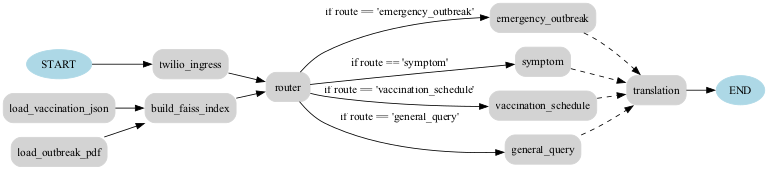

In [6]:
import graphviz
from IPython.display import Image, display
from langgraph.graph import START, END

nodes = [
    "twilio_ingress",
    "load_vaccination_json",
    "load_outbreak_pdf",
    "build_faiss_index",
    "router",
    "emergency_outbreak",
    "symptom",
    "vaccination_schedule",
    "general_query",
    "translation",  
]

dot = graphviz.Digraph(comment="HealthGraph WhatsApp Pipeline (Conditional Paths)")
dot.attr(rankdir="LR", size="8,5")

dot.node(str(START), "START", shape="oval", style="filled", color="lightblue")
dot.node(str(END), "END", shape="oval", style="filled", color="lightblue")

for n in nodes:
    dot.node(n, n, shape="box", style="rounded,filled", color="lightgray")

edges = [
    (START, "twilio_ingress"),
    ("twilio_ingress", "router"),
    ("load_vaccination_json", "build_faiss_index"),
    ("load_outbreak_pdf", "build_faiss_index"),
    ("build_faiss_index", "router"), 
]
for src, dst in edges:
    dot.edge(str(src), str(dst))

router_conditions = {
    "emergency_outbreak": "if route == 'emergency_outbreak'",
    "symptom": "if route == 'symptom'",
    "vaccination_schedule": "if route == 'vaccination_schedule'",
    "general_query": "if route == 'general_query'",
}

for node, label in router_conditions.items():
    dot.edge("router", node, label=label)

for node in router_conditions.keys():
    dot.edge(node, "translation", style="dashed")

dot.edge("translation", str(END))

display(Image(dot.pipe(format="png")))


In [7]:
disk_mem = DiskConversationMemory()

state = HealthGraphState(
    disk_memory=disk_mem
)
state = node_load_outbreak_pdf(state)  

state = node_build_faiss_index(state)  

state.twilio_payload = {"Body": "the pain is very bad and i have headache since 1 hour"}
final_state = app.invoke(state)  

print("Final Response:\n", final_state["response"]["original"])
print("Final Response:\n", final_state["response"]["translation_raw"])


/var/folders/tc/82s4ljdd4vb27_xxzh25mv0w0000gn/T/ipykernel_22547/1825304142.py:39: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  self.memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


Loaded memory from chat_memory.pkl
Loaded FAISS index from /Users/aashutoshkumar/Documents/Projects/healthgraph-assistant/exp/faiss_index
symptom


/var/folders/tc/82s4ljdd4vb27_xxzh25mv0w0000gn/T/ipykernel_22547/1825304142.py:228: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  state.response = qa_chain.run(state.user_message)


Final Response:
 Okay, based on what you're telling me and the information I have, it sounds like you need to seek medical attention urgently.

Here's why:

*   **Rapid-onset, severe pain around one eye:** This is a key symptom mentioned in the text.
*   **Headache since 1 hour:** The sudden onset is concerning.

Given these symptoms, it could be a few things, but one possibility mentioned is a condition that requires immediate treatment to prevent vision loss.

**What you need to do:**

1.  **Go to the nearest emergency room or urgent care clinic immediately.** Time is important in these situations.
2.  **Tell the medical staff about your symptoms:** Be sure to mention the sudden, severe pain around your eye and the headache that started an hour ago.
3.  **If you are unable to get immediate medical attention (delay of >1 hour):** The text suggests that you take eye drops (0.5% timolol maleate ± 2% pilocarpine) and acetazolamide 500mg by mouth. However, **only do this if you are absolu

In [ ]:
from flask import Flask, request
from twilio.twiml.messaging_response import MessagingResponse

app_flask = Flask(__name__)

@app_flask.route("/", methods=["GET"])
def home():
    return "Bot is running!"

@app_flask.route("/whatsapp", methods=["POST"])
def whatsapp_webhook():
    incoming_msg = request.values.get("Body", "").strip()
    sender = request.values.get("From", "")
    print("Incoming:", incoming_msg, sender)

    resp = MessagingResponse()
    try:
        state = HealthGraphState(
            twilio_payload={"Body": incoming_msg, "From": sender},
            disk_memory=disk_mem
        )

        state = node_load_outbreak_pdf(state)  

        state = node_build_faiss_index(state)  
        final_state = app.invoke(state)
        response_text = final_state["response"]
        if hasattr(response_text, "content"):
            response_text = response_text['original']
        resp.message(response_text['original'])
        print(response_text['original'])
    except Exception as e:
        print("Error:", e)
        resp.message("Oops! Something went wrong.")

    return response_text['original']

if __name__ == "__main__":
    app_flask.run(host="0.0.0.0", port=6000)  


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:6000
 * Running on http://10.143.128.57:6000
Press CTRL+C to quit


Incoming: What vaccine should give for my infant whatsapp:+919978408385
Loaded FAISS index from /Users/aashutoshkumar/Documents/Projects/healthgraph-assistant/exp/faiss_index
vaccination_schedule


127.0.0.1 - - [22/Sep/2025 17:12:00] "POST /whatsapp HTTP/1.1" 200 -


To provide a precise answer, I need to know your infant's current age. However, I can give you a general checklist of vaccines recommended for infants, based on the provided schedule:

**At birth or within 24 hours:**

*   [ ] Bacillus Calmette Guerin (BCG)
*   [ ] Hepatitis B (Birth dose)
*   [ ] Oral Polio Vaccine (OPV-0)

**At 6, 10, and 14 weeks:**

*   [ ] Oral Polio Vaccine (OPV-1,2,3)
*   [ ] Pentavalent (1,2,3)
*   [ ] Rotavirus Vaccine (RVV-1,2,3)
*   [ ] Inactivated Polio Vaccine (fIPV-1,2)

**At 6 weeks and 14 weeks:**

*   [ ] Pneumococcal Conjugate Vaccine (PCV-1,2,Booster)

**At 9-12 months:**

*   [ ] Measles Rubella (MR-1)
*   [ ] Japanese Encephalitis (JE-1) (endemic districts only)
*   [ ] Vitamin A (1st dose)


In [22]:
app_flask = Flask(__name__)

@app_flask.route("/", methods=["GET"])
def home():
    return "Bot is running!"

@app_flask.route("/whatsapp", methods=["POST"])
def whatsapp_webhook():
    incoming_msg = request.values.get("Body", "").strip()
    sender = request.values.get("From", "")
    print("Incoming:", incoming_msg, sender)

    resp = MessagingResponse()
    try:
        state = HealthGraphState(
            twilio_payload={"Body": incoming_msg, "From": sender},
            disk_memory=disk_mem
        )

        # Load docs + build FAISS (only needed for outbreak queries)
        state = node_load_outbreak_pdf(state)
        state = node_build_faiss_index(state)

        # Run workflow
        final_state = app.invoke(state)
        response_text = final_state["response"]

        # Handle dict vs string
        if isinstance(response_text, dict):
            reply = response_text.get("original", str(response_text))
        else:
            reply = str(response_text)

        resp.message(reply)
        print("Sending to WhatsApp:", reply)

    except Exception as e:
        print("Error:", e)
        resp.message("Oops! Something went wrong.")

    # ✅ Always return TwiML
    return str(resp)


if __name__ == "__main__":
    app_flask.run(host="0.0.0.0", port=4000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:4000
 * Running on http://192.0.0.2:4000
Press CTRL+C to quit
127.0.0.1 - - [22/Sep/2025 17:50:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Sep/2025 17:50:38] "GET /favicon.ico HTTP/1.1" 404 -


Incoming: I have fever whatsapp:+919978408385
Loaded FAISS index from /Users/aashutoshkumar/Documents/Projects/healthgraph-assistant/exp/faiss_index
symptom


127.0.0.1 - - [22/Sep/2025 17:53:56] "POST /whatsapp HTTP/1.1" 200 -


Sending to WhatsApp: Okay, I understand you have a fever.

Based on the information provided, a fever can be caused by many things, from a common cold to more serious infections.

To figure out what might be causing your fever, it's important to consider:

*   **Other symptoms:** Do you have a cough, sore throat, headache, or any other symptoms?
*   **How long you've had the fever:** Has it been a few days or longer?
*   **Your medical history:** Do you have any underlying health conditions?
*   **Recent travel:** Have you traveled to any areas where specific diseases are common?

It's best to see a doctor to get a proper diagnosis. They can ask you more questions, do a physical exam, and run tests if needed to figure out the cause of your fever and recommend the right treatment.


In [24]:
from flask import Flask, request, Response
from twilio.twiml.messaging_response import MessagingResponse
import traceback
import re

app_flask = Flask(__name__)

@app_flask.route("/", methods=["GET"])
def home():
    return "Bot is running!"

@app_flask.route("/whatsapp", methods=["POST"])
def whatsapp_webhook():
    try:
        # 1️⃣ Get incoming WhatsApp payload
        incoming_msg = request.values.get("Body", "").strip()
        sender = request.values.get("From", "")
        print(f"\n=== Incoming Message ===\nFrom: {sender}\nBody: {incoming_msg}\n=======================")

        # 2️⃣ Initialize Twilio response
        resp = MessagingResponse()

        # 3️⃣ Prepare HealthGraph state
        state = HealthGraphState(
            twilio_payload={"Body": incoming_msg, "From": sender},
            disk_memory=disk_mem
        )

        # 4️⃣ Load outbreak docs & build FAISS (needed for outbreak queries)
        state = node_load_outbreak_pdf(state)
        state = node_build_faiss_index(state)

        # 5️⃣ Invoke workflow
        final_state = app.invoke(state)
        response_text = final_state["response"]

        # 6️⃣ Convert response safely (handles dicts, nested content)
        if isinstance(response_text, dict):
            reply = response_text.get("original") or response_text.get("translation_raw") or str(response_text)
        else:
            reply = str(response_text)

        # 7️⃣ Remove unsupported markdown for WhatsApp
        reply = re.sub(r"[*_~]", "", reply)

        # 8️⃣ Split long messages into 1500-char chunks and send
        max_len = 1500
        if len(reply) > max_len:
            for i in range(0, len(reply), max_len):
                chunk = reply[i:i+max_len]
                resp.message(chunk)
        else:
            resp.message(reply)

        # 9️⃣ Log outgoing TwiML
        print(f"\n=== Outgoing Twilio XML ===\n{str(resp)}\n==========================")

    except Exception as e:
        print("Webhook error:", e)
        traceback.print_exc()
        resp = MessagingResponse()
        resp.message("Oops! Something went wrong while processing your message.")

    #  🔟 Always return valid TwiML
    return Response(str(resp), mimetype="application/xml")


if __name__ == "__main__":
    app_flask.run(host="0.0.0.0", port=4000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:4000
 * Running on http://192.0.0.2:4000
Press CTRL+C to quit



=== Incoming Message ===
From: whatsapp:+919978408385
Body: I have fever
Loaded FAISS index from /Users/aashutoshkumar/Documents/Projects/healthgraph-assistant/exp/faiss_index
symptom


127.0.0.1 - - [22/Sep/2025 18:02:32] "POST /whatsapp HTTP/1.1" 200 -



=== Outgoing Twilio XML ===
<?xml version="1.0" encoding="UTF-8"?><Response><Message>Okay, I understand you have a fever.

Based on the information you provided, a fever can be caused by many things, from a common cold to more serious infections.

To figure out what's causing your fever, it's important to consider other symptoms you might have. For example, do you have a cough, sore throat, or any other aches and pains?

If your fever is high, doesn't go away after a few days, or you have other concerning symptoms, it's important to see a doctor to get it checked out.</Message></Response>


In [25]:
from flask import Flask, request, Response
from twilio.twiml.messaging_response import MessagingResponse

app_flask = Flask(__name__)

@app_flask.route("/whatsapp", methods=["POST"])
def whatsapp_webhook():
    # Print incoming payload for debugging
    incoming_msg = request.values.get("Body", "").strip()
    sender = request.values.get("From", "")
    print(f"Incoming message from {sender}: {incoming_msg}")

    # Prepare a simple reply
    resp = MessagingResponse()
    resp.message(f"Hello! I received your message: {incoming_msg}")

    # Return TwiML with correct content type
    return Response(str(resp), mimetype="application/xml")

if __name__ == "__main__":
    # Make sure this port matches your ngrok tunnel
    app_flask.run(host="0.0.0.0", port=4000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:4000
 * Running on http://192.0.0.2:4000
Press CTRL+C to quit
127.0.0.1 - - [22/Sep/2025 18:03:53] "POST /whatsapp HTTP/1.1" 200 -


Incoming message from whatsapp:+919978408385: Hello


In [ ]:
from flask import Flask, request, Response
from twilio.twiml.messaging_response import MessagingResponse
from twilio.rest import Client
from threading import Thread
import traceback

# -----------------------------
# Initialize Flask
# -----------------------------
app_flask = Flask(__name__)

# -----------------------------
# Twilio credentials
# -----------------------------
TWILIO_SID = os.getenv("TWILIO_SID")
TWILIO_AUTH = os.getenv("TWILIO_AUTH")
TWILIO_WHATSAPP_NUMBER = "whatsapp:+14155238886"  # Twilio sandbox number

client = Client(TWILIO_SID, TWILIO_AUTH)

# -----------------------------
# Preload FAISS & heavy resources
# -----------------------------
print("Loading FAISS index...")
state_for_index = HealthGraphState(disk_memory=disk_mem)
state_for_index = node_load_outbreak_pdf(state_for_index)
state_for_index = node_build_faiss_index(state_for_index)
faiss_index_ready = state_for_index.local_vectorstore
print("FAISS ready")

# -----------------------------
# Background HealthGraph processor
# -----------------------------
def process_healthgraph(sender, incoming_msg):
    try:
        state = HealthGraphState(
            twilio_payload={"Body": incoming_msg, "From": sender},
            disk_memory=disk_mem
        )
        # Reuse preloaded FAISS
        state.local_vectorstore = faiss_index_ready

        # Run your workflow
        final_state = app.invoke(state)
        response_text = final_state["response"]

        # Convert dict/string safely
        if isinstance(response_text, dict):
            reply = response_text.get("original") or response_text.get("translation_raw") or str(response_text)
        else:
            reply = str(response_text)

        # Split long messages if needed (Twilio limit ~1600 chars)
        max_len = 1500
        for i in range(0, len(reply), max_len):
            chunk = reply[i:i+max_len]
            client.messages.create(
                body=chunk,
                from_=TWILIO_WHATSAPP_NUMBER,
                to=sender
            )

        print(f"✅ Sent reply to {sender}")

    except Exception as e:
        print("Error in background processing:", e)
        traceback.print_exc()
        client.messages.create(
            body="Oops! Something went wrong while processing your request.",
            from_=TWILIO_WHATSAPP_NUMBER,
            to=sender
        )

# -----------------------------
# WhatsApp webhook
# -----------------------------
@app_flask.route("/whatsapp", methods=["POST"])
def whatsapp_webhook():
    incoming_msg = request.values.get("Body", "").strip()
    sender = request.values.get("From", "")
    print(f"\nIncoming message from {sender}: {incoming_msg}")

    # Respond immediately to Twilio to avoid timeout
    resp = MessagingResponse()
    resp.message("Thanks! Processing your request, you'll get the answer shortly.")

    # Start background thread
    Thread(target=process_healthgraph, args=(sender, incoming_msg)).start()

    return Response(str(resp), mimetype="application/xml")

# -----------------------------
# Root route
# -----------------------------
@app_flask.route("/", methods=["GET"])
def home():
    return "Bot is running!"

# -----------------------------
# Run Flask app
# -----------------------------
if __name__ == "__main__":
    app_flask.run(host="0.0.0.0", port=4000)


Loading FAISS index...
Loaded FAISS index from /Users/aashutoshkumar/Documents/Projects/healthgraph-assistant/exp/faiss_index
FAISS ready
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:4000
 * Running on http://192.0.0.2:4000
Press CTRL+C to quit
127.0.0.1 - - [22/Sep/2025 18:11:18] "POST /whatsapp HTTP/1.1" 200 -



Incoming message from whatsapp:+919978408385: I have fever
symptom
✅ Sent reply to whatsapp:+919978408385
